In [260]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import statsmodels.api as sm
import sys
from stocktrends import Renko
import talib
import yfinance as yf
import copy
from alpha_vantage import timeseries

In [261]:
# !{sys.executable} -m pip install alpha_vantage

### Tech indicators

In [262]:
def ATR(DF, n):
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
#     df['ATR'] = df['TR'].ewm(span=n, adjust=False, min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1).dropna()
    return df2.tail(5)

### KPI for the strategy

In [249]:
def CAGR(DF):
    df = DF.copy()
#     df['daily_ret'] = df['close'].pct_change()
    df['cum_ret'] = (1 + df['mon_ret']).cumprod()
#     print(df)
    n = len(df) / 12
    CAGR = (df['cum_ret'].tolist()[-1]) ** (1/n) - 1
    return CAGR


def Vola(DF):
    df = DF.copy()
#     df['daily_ret'] = df['close'].pct_change()
    vola = df['mon_ret'].std()
    annual_vola = vola * np.sqrt(12)
#     week_vola = vola * np.sqrt(52)
    month_vola = vola * np.sqrt(12)
    return annual_vola


def Sharpe(DF, rf):
    df = DF.copy()
    sr = ((CAGR(df) - rf) / Vola(df))
    return sr


def Sortino(DF, rf):
    df = DF.copy()
    df['mon_ret'] = df['close'].pct_change()
    neg_vola = df[df['mon_ret'] < 0]['mon_ret'].std() * np.sqrt(12)
    sortino = (CAGR(df) - rf) / neg_vola
    return sortino


def max_dd(DF):
    df = DF.copy()
#     df['mon_ret'] = df['close'].pct_change()
    df['cum_ret'] = (1 + df['mon_ret']).cumprod()
    df['cum_roll_max'] = df['cum_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cum_ret']
    df['drawdown_pct'] = df['drawdown'] / df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd


def Calmar(DF):
    df = DF.copy()
    clmr = CAGR(df) / max_dd(df)
    return clmr 

### Data fetching

##### Bitcoin

##### Stocks

In [250]:
tickers = ["MMM", "AXP", "T", "BA", "CAT" ,"CVX", "CSCO", "KO", "XOM", "GE", "GS", "HD",
           "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PFE", "PG", "TRV",
           "UTX", "UNH", "VZ" ,"V" ,"WMT" ,"DIS"]
start_date_stocks = '2000-01-01'
# end_date = 

In [251]:
ohlc_mon = {} # to store stock data
attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store stock whose close price was successfuly extracted

while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] # removing stocks which tiker has been extracted
    for i in range(len(tickers)):
        try:
            ohlc_mon[tickers[i]] = yf.download(tickers[i], start=start_date_stocks, interval = '1mo')
            ohlc_mon[tickers[i]].dropna(inplace=True)
            ohlc_mon[tickers[i]].rename(columns={'Adj Close': 'close'}, inplace=True)
            drop.append(tickers[i])
        except:
            print(tickers[i], 'failed to fetch data..retrying')
            continue
    attempt += 1
    
tickers = ohlc_mon.keys() #redefine tickers variable after removing any tickers with corrupted data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

#### strategy "Portfolio Rebalancing"

In [252]:
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print('calculating monthly return', ticker)
    ohlc_dict[ticker]['mon_ret'] = ohlc_dict[ticker]['close'].pct_change()
    return_df[ticker] = ohlc_dict[ticker]['mon_ret']
# return_df

calculating monthly return MMM
calculating monthly return AXP
calculating monthly return T
calculating monthly return BA
calculating monthly return CAT
calculating monthly return CVX
calculating monthly return CSCO
calculating monthly return KO
calculating monthly return XOM
calculating monthly return GE
calculating monthly return GS
calculating monthly return HD
calculating monthly return IBM
calculating monthly return INTC
calculating monthly return JNJ
calculating monthly return JPM
calculating monthly return MCD
calculating monthly return MRK
calculating monthly return MSFT
calculating monthly return NKE
calculating monthly return PFE
calculating monthly return PG
calculating monthly return TRV
calculating monthly return UTX
calculating monthly return UNH
calculating monthly return VZ
calculating monthly return V
calculating monthly return WMT
calculating monthly return DIS


In [253]:
DF = return_df
m = 6
x = 3
portfolio = ["MMM", "AXP", "T", "BA", "CAT" ,"CVX"]

In [254]:
# func to calculate portfolio return iterativly

def pfio(DF, m, x):
    """Return cumulative portfolio returns
    DF= dataframe
    m = number of stocks in portfolio
    x = number of underperforming stocks to be removed from portfolio monthly    
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(1, len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df[[t for t in tickers if t not in portfolio]].iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
#         new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist() # replace all stocks not just x
        new_picks
        portfolio = portfolio + new_picks
#         print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=['mon_ret'])
    return monthly_ret_df

In [255]:
print(CAGR(pfio(DF, m, x)))
print(Sharpe(pfio(DF, m ,x), 0.02))
print(max_dd(pfio(DF, m, x)))

0.05747065613757196
0.22267229209242145
0.651233018893747


In [256]:
spy = yf.download('SPY', start=start_date_stocks, interval = '1mo')
spy.dropna(inplace=True)
spy['mon_ret'] = spy['Adj Close'].pct_change()
spy.rename(columns={'Adj Close': 'close'}, inplace=True)
spy

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,close,Volume,mon_ret
Date,,,,,,,
2000-01-01,148.250000,148.250000,135.000000,139.562500,96.411942,1.567708e+08,NaN
2000-02-01,139.750000,144.562500,132.718750,137.437500,94.943932,1.869383e+08,-0.015226
2000-03-01,137.625000,155.750000,135.031250,150.375000,103.881409,2.475949e+08,0.094134
2000-04-01,150.125000,153.109375,133.500000,145.093750,100.487762,2.292462e+08,-0.032668
2000-05-01,146.562500,148.484375,136.500000,142.812500,98.907852,1.610240e+08,-0.015722
...,...,...,...,...,...,...,...
2019-09-01,290.570007,302.630005,289.269989,296.769989,295.405792,1.303830e+09,0.014772
2019-10-01,297.739990,304.549988,284.820007,303.329987,303.329987,1.386748e+09,0.026825
2019-11-01,304.920013,315.480011,304.739990,314.309998,314.309998,1.037124e+09,0.036198


In [257]:
print(CAGR(spy))
print(Sharpe(spy, 0))
print(max_dd(spy))

0.06165655099517009
0.4221510335772905
0.5078480199917982


#### visualization

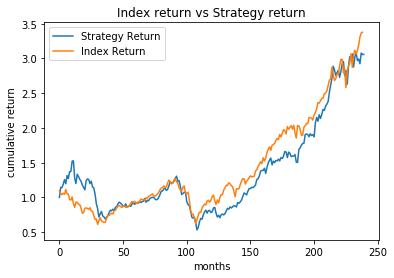

In [258]:
fig, ax = plt.subplots()
plt.plot((1 + pfio(DF, m, x)).cumprod())
plt.plot((1 + spy['mon_ret'][2:].reset_index(drop=True)).cumprod())
plt.title('Index return vs Strategy return')
plt.ylabel('cumulative return')
plt.xlabel('months')
ax.legend(['Strategy Return', 'Index Return']);

#### strategy "Intraday Resistance Breakout"